# Calculate the scattering coefficients of a time series

This notebook demonstrates how to calculate the scattering coefficients of a time series. The example here uses `obspy` to load seismic data. One can adapt it to any time series as the loading function is arbitrary.

In [2]:
import pandas as pd
import numpy as np
import obspy 

from matplotlib import dates as mdates
from matplotlib import pyplot as plt
from scatseisnet import ScatteringNetwork, signal

In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_formats = ['svg']

## Meta parameters

The following cell defines the meta parameter of the network:

- `SEGMENT` represents the window size used to chunk the data into pieces before passing it to the scattering network. We define it here in seconds since we know the data sampling rate.
-`STEP` defines the sliding duration between two consecutive windows.
- `POOLING` indicates the way the scattering coefficients are calculated over a window. It may be `"max"` for maximum pooling and `"avg"` for mean pooling.
- `OCTAVES` indicates the number of octaves per layer. This value can be a tuple where the number of elements defines the number of layers. 
- `RESOLUTION` represents the number of wavelets per octave (must be of the size of `OCTAVES`)
- `QUALITY` represents the quality factor of the mother wavelet (must be of the size of `OCTAVES`)
- `SAMPLING_RATE` and other values allow turning the window and stepping durations into samples. If the sampling rate is unknown, it can be turned to a reduced frequency (1) or angular frequency (2$\pi$).

In [4]:
SEGMENT = 600
STEP = 300
SAMPLING_RATE = 40
SAMPLES_PER_SEGMENT = int(SEGMENT * SAMPLING_RATE)
SAMPLES_PER_STEP = int(STEP * SAMPLING_RATE)
BANKS = (
    {"octaves": 6, "resolution": 8, "quality": 1},
    {"octaves": 8, "resolution": 2, "quality": 3}
)

## Network definition

We instantiate the network from the meta parameters defined in the previous cell. The following cell allows defining the scattering network graph but does not compile it. The compilation stage occurs at the first use of the network.

In [5]:
net = ScatteringNetwork(
    BANKS, bins=SAMPLES_PER_SEGMENT, sampling_rate=SAMPLING_RATE
)

## Show the filter banks

We can easily access the different properties of the network and visualize the filter banks, for instance. Note that if the notebook implements the CPU version, there is no need to transfer the data to the CPU device with the `get` method.

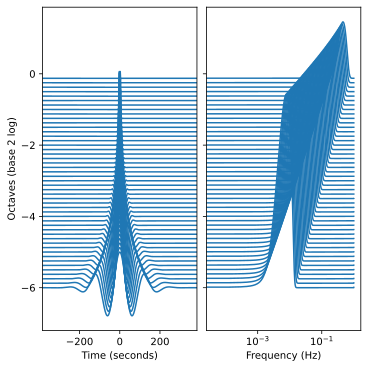

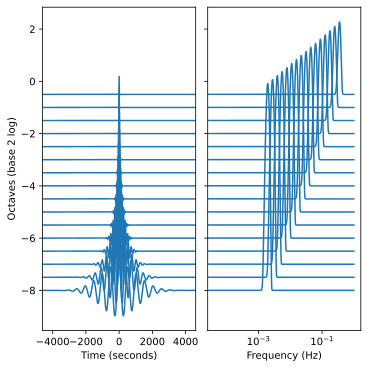

In [6]:
# Loop over network layers
for bank in net.banks:
    
    # Crete axes
    fig, ax = plt.subplots(1, 2, sharey=True)

    # Show each wavelet
    iterable = zip(bank.wavelets.get(), bank.spectra.get(), bank.ratios)
    for wavelet, spectrum, ratio in iterable:
        
        # Time domain
        ax[0].plot(bank.times, wavelet.real + ratio, "C0")
    
        # Spectral domain
        ax[1].plot(bank.frequencies, np.log(np.abs(spectrum) + 1) + ratio, "C0")

    # Limit view to three times the temporal width of largest wavelet
    width_max = 3 * bank.widths.max()
    
    # Labels
    ax[0].set_ylabel("Octaves (base 2 log)")
    ax[0].set_xlabel("Time (seconds)")
    ax[0].set_xlim(-width_max, width_max)
    ax[1].set_xscale("log")
    ax[1].set_xlabel("Frequency (Hz)")

In [7]:
def load_data(filepath, trim=None):
    """Users: manage.
    
    Give traces as a numpy array.
    times : (n_times, )
    data: (n_channels, n_times)
    """
    stream = obspy.read(filepath)
    stream.detrend("linear")
    stream.merge(method=1)
    stream.detrend("linear")
    stream.detrend("linear")
    stream.filter(type="highpass", freq=1)
    if trim is not None:
        stream.trim(*trim)
    else:
        starttime = max([tr.stats.starttime for tr in stream])
        endtime = min([tr.stats.endtime for tr in stream])
        stream.trim(starttime, endtime, fill_value=0)
    
    # Numpyification
    times = stream[0].times("matplotlib")
    data = np.array([trace.data for trace in stream])
        
    return times, data

In [9]:
files = ["/nfs/wfranklab001/lseydoux/UW/waveforms/UW.GNW..BH*__20190507T000000Z__20190508T000000Z.mseed"]
print(files)

['/nfs/wfranklab001/lseydoux/UW/waveforms/UW.GNW..BH*__20190507T000000Z__20190508T000000Z.mseed']


## Loop over dataset

This loop works naturally over a set of files to be transformed. 
The scattering coefficients should be saved with `pickle`(or any other preferred serializer) in order to be used later.

In [11]:
POOLING = "max"

# Transform loop
for file in files:

    # Extract stream
    times, data = load_data(file)
    
    # Segmentization
    data_segments = signal.segmentize(data, SAMPLES_PER_SEGMENT, SAMPLES_PER_STEP)
    times_scat = signal.segmentize(times, SAMPLES_PER_SEGMENT, SAMPLES_PER_STEP)[:, 0]
    
    # Scattering transform
    scattering_coefficients = net.transform(data_segments, POOLING)
    

## Show some output

In the following example one can observe the scattering coefficients.

Text(0, 0.5, 'Frequency (Hz)')

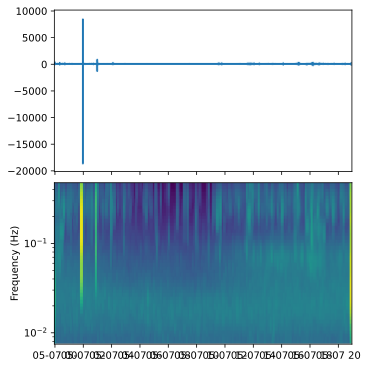

In [13]:
CHANNEL = 0

fig, ax = plt.subplots(2, sharex=True)

frequencies = net.banks[0].centers
timestamps = pd.to_datetime(times, unit="D")
timestamps_scats = pd.to_datetime(times_scat, unit="D")

first_order_scattering_coefficients = np.squeeze(scattering_coefficients[0][:, CHANNEL, :].T)
first_order_scattering_coefficients = np.log(first_order_scattering_coefficients)

ax[0].plot(timestamps, data[CHANNEL], rasterized=True)

ax[1].pcolormesh(times_scat, frequencies, first_order_scattering_coefficients, rasterized=True)
ax[1].set_yscale("log")
ax[1].set_ylabel("Frequency (Hz)")
